In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn import preprocessing
import plotly.express as px
from sklearn.datasets import make_blobs
plt.style.use('dark_background')

In [2]:
df = pd.read_csv("./dataset/wine-clustering.csv")
df.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
df.describe()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [4]:
df.dtypes

Alcohol                 float64
Malic_Acid              float64
Ash                     float64
Ash_Alcanity            float64
Magnesium                 int64
Total_Phenols           float64
Flavanoids              float64
Nonflavanoid_Phenols    float64
Proanthocyanins         float64
Color_Intensity         float64
Hue                     float64
OD280                   float64
Proline                   int64
dtype: object

In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
import numpy as np

In [6]:
def preprocess(df: pd.DataFrame) -> np.ndarray:
    df_processed = df.copy()

    # Fill missing values
    for col in df_processed.columns:
        if df_processed[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df_processed[col]):
            df_processed[col] = df_processed[col].fillna(df_processed[col].mode()[0])
        else:
            df_processed[col] = df_processed[col].fillna(df_processed[col].mean())

    # Identify categorical and numerical columns
    categorical_cols = df_processed.select_dtypes(include=['object', 'category']).columns
    numerical_cols = df_processed.select_dtypes(exclude=['object', 'category']).columns

    # One-hot encode categorical columns if present
    if len(categorical_cols) > 0:
        ohe = OneHotEncoder(sparse_output=False)
        encoded_array = ohe.fit_transform(df_processed[categorical_cols])
        encoded_df = pd.DataFrame(encoded_array,
                                  columns=ohe.get_feature_names_out(categorical_cols),
                                  index=df_processed.index)
    else:
        encoded_df = pd.DataFrame(index=df_processed.index)

    # Keep numerical data if present
    if len(numerical_cols) > 0:
        numeric_df = df_processed[numerical_cols]
    else:
        numeric_df = pd.DataFrame(index=df_processed.index)

    # Combine encoded and numerical
    df_final = pd.concat([numeric_df, encoded_df], axis=1)

    if df_final.shape[1] == 0:
        raise ValueError("No features to process: both numerical and categorical columns are missing.")

    # Standard scaling
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df_final)

    return data_scaled

In [7]:
import numpy as np

class KMeans:
    def __init__(self, k=3, max_iters=100, tolerance=1e-4):
        self.k = k
        self.max_iters = max_iters
        self.tolerance = tolerance

    def fit(self, data):
        n_samples = data.shape[0]
        np.random.seed(42)
        random_indices = np.random.choice(n_samples, self.k, replace=False)
        self.centroids = data[random_indices]

        for _ in range(self.max_iters):
            self.labels = self._assign_clusters(data)
            new_centroids = np.array([data[self.labels == i].mean(axis=0) for i in range(self.k)])
            if np.all(np.abs(self.centroids - new_centroids) < self.tolerance):
                break
            self.centroids = new_centroids

    def _assign_clusters(self, data):
        distances = np.linalg.norm(data[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

    def predict(self, data):
        return self._assign_clusters(data)


C:\Users\Asus\AppData\Local\Temp\ipykernel_19748\2024568696.py:6: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if df_processed[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df_processed[col]):


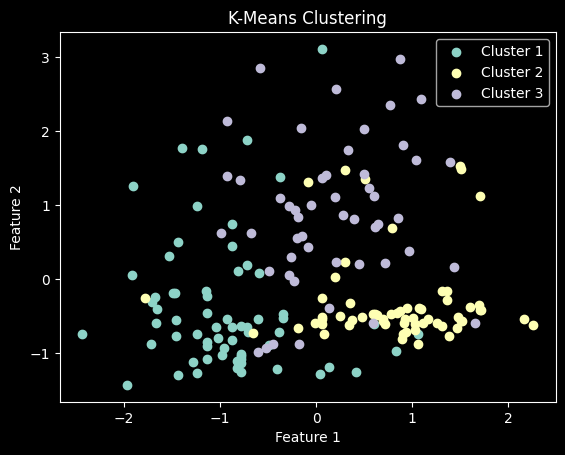

In [10]:
# df = pd.read_csv(path)
column_names = df.columns.tolist()
data = preprocess(df)

clusterx = 3

model = KMeans(k=clusterx)
model.fit(data)
labels = model.predict(data)

if data.shape[1] >= 2:
    plt.figure()
    for cluster_id in range(clusterx):
        cluster_points = data[labels == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id+1}')
    plt.title("K-Means Clustering")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()


In [1]:
import pandas as pd

df = pd.read_csv("./dataset/consumer_behavior_dataset.csv")

df.dtypes

user_id               object
product_id            object
category              object
price                float64
discount_applied     float64
payment_method        object
purchase_date         object
pages_visited          int64
time_spent             int64
add_to_cart            int64
abandoned_cart         int64
rating                 int64
review_text           object
sentiment_score      float64
age                    int64
gender                object
income_level          object
location              object
purchase_decision      int64
dtype: object